# Lysine Reactivity Ratios
Check that the ratios as presented in https://www.nature.com/articles/nature09472 and https://pubs.acs.org/doi/full/10.1021/acschembio.7b00125 actually makes sense

In [1]:
import tellurium as te
import pandas as pd
import numpy as np
import seaborn as sns
import dataframe_image as dfi
from xlink_kme_sbml.library import sbml_sim_helper

In [2]:
str_time = 'time'
str_var = 'variable'
str_value = 'value'
str_species = 'species'
str_pos = 'pos'
str_is_linker = "is_linker"
str_conc_linker = "linker_conc"
str_conc_linker_initical = "initial linker conc"
str_reaction_ratio = "Reaction Ratio"
str_linker_ratio = "Linker Ratio"
str_klys = 'klys'


str_species_mono_base = "Mono"
str_species_mono_hydro = "MonoHydro"
str_species_mono_sum = "MonoSum"
str_species_crosslinker = "Crosslinker"
str_species_monolinker = "Monolinker"
str_species_lys = "LYS"

In [3]:
def create_melt_df(df):
    df_melt = pd.melt(df, id_vars=[str_time])
    df_melt[str_var] = df_melt[str_var].str.replace("\[|\]", "", regex=True)
    df_melt = create_type_pos_columns(df_melt)
    df_melt.loc[df_melt[str_value] < 1e-5, str_value] = 1e-5
    mask_linker_species = df_melt[str_species].str.contains(f"{str_species_crosslinker}|{str_species_monolinker}")
    df_melt[str_is_linker] = mask_linker_species
    df_melt[str_conc_linker_initical] = df_melt[(df_melt[str_time]== 0) & (df_melt[str_var] == str_species_crosslinker)][str_value][0]
    return df_melt

In [4]:
def create_type_pos_columns(df_melt):
    df_melt = df_melt.copy(deep=True)
    df_melt[[str_species, str_pos]] = df_melt[str_var].str.split("_", expand=True)
    df_melt[str_pos] = df_melt[str_pos].fillna(1)
    df_melt[str_pos] = df_melt[str_pos].astype(int)
    df_melt[str_pos] = pd.Categorical(df_melt[str_pos])
    return df_melt

In [5]:
def set_custom_vars(rr, custom_vars):
    for k,v in custom_vars.items():
        setattr(rr, k, v)

In [6]:
def get_res_df(rr, sim_time=30, linker_conc=20, custom_vars=None, reactivity_factor=1):
    no_of_points = sim_time*10 + 1
    rr.resetToOrigin()
    set_custom_vars(rr, {**custom_vars, "Crosslinker": linker_conc})
    change_klys_reactivity(rr, factor=reactivity_factor)
    #create_klys_mult_dist(rr)
    results = rr.simulate(0, sim_time, points=no_of_points)
    df_res = pd.DataFrame(results, columns=results.colnames)
    df_melt = create_melt_df(df_res)    
    return df_melt

In [7]:
def add_reaction_ratio(df_list, df_ref):
    for df in df_list:
        df[str_linker_ratio] = df[str_conc_linker_initical] / df_ref[str_conc_linker_initical]
        df[str_reaction_ratio] = df[str_value] / df_ref[str_value]
        

In [8]:
def get_klys_df(custom_vars_dict):
    klys_dict = {}
    for kl in custom_vars_dict.keys():
        if str_klys in kl:
            klys_dict[kl] = custom_vars_dict[kl]
    pos_list = [int(key.split("_")[1]) for key in klys_dict]
    #dict(zip(df_c1['variable'], df_c1['value']))
    return pd.DataFrame.from_dict({str_var: list(klys_dict.keys()), str_klys: list(klys_dict.values()), str_pos: pos_list})

In [9]:
def change_klys_reactivity(rr, factor):
    vars_klys = sbml_sim_helper.get_rr_const_dict(rr, str_klys)
    vars_klys_new = {}
    for klys in vars_klys.keys():
        vars_klys_new[klys] = vars_klys[klys] * factor
    set_custom_vars(rr, vars_klys_new)

In [10]:
def create_klys_mult_dist(rr, scale1=0.001, scale2=0.01, scale3=0.1, scale1_start=1, scale2_start=16, scale3_start=86, end=100):
    vars_klys = {}
    for n in range(scale1_start, scale2_start):
        vars_klys[f"{str_klys}_{n}"] = np.random.exponential(scale=scale1)
    for n in range(scale2_start, scale3_start):
        vars_klys[f"{str_klys}_{n}"] = np.random.exponential(scale=scale2)
    for n in range(scale3_start, end+1):
        vars_klys[f"{str_klys}_{n}"] = np.random.exponential(scale=scale3)
    return vars_klys 

In [11]:
rr = te.loadSBMLModel("/home/kai/Nextcloud-unikn/Coding/xlink_kme_sbml/output/model_example_mono_only_simple_100lys.xml")

In [12]:
rr = te.loada("/home/kai/Nextcloud-unikn/Coding/xlink_kme_sbml/output/model_example_mono_only_simple_100lys_antimony_s.txt")

In [13]:
sim_time = 60
# reduce reactivity by a factor of 10
reactivity_factor = 0.005

In [14]:
custom_vars = {'kh': 1e-05, 'kon': 1e-3, 'koff': 1e-1, "klys_1": 5, "klys_2": 10, "klys_3": 15, "klys_4": 20, "klys_5": 50}
             # "klys_96": 0.5, "klys_97": 0.1, "klys_98": 0.05, "klys_99": 0.01, "klys_100": 0.005}

In [15]:
#multi_dist_klys = create_klys_mult_dist(rr, scale1=0.1, scale2=0.01, scale3=0.001, scale1_start=1, scale2_start=16, scale3_start=31, end=100)
#custom_vars = {**custom_vars, **multi_dist_klys}

In [39]:
df_melt_2 = get_res_df(rr, sim_time=sim_time, linker_conc=2, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_10 = get_res_df(rr, sim_time=sim_time, linker_conc=10, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_20 = get_res_df(rr, sim_time=sim_time, linker_conc=20, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_50 = get_res_df(rr, sim_time=sim_time, linker_conc=50, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
#df_melt_80 = get_res_df(rr, sim_time=sim_time, linker_conc=75, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_100 = get_res_df(rr, sim_time=sim_time, linker_conc=100, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_200 = get_res_df(rr, sim_time=sim_time, linker_conc=200, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_500 = get_res_df(rr, sim_time=sim_time, linker_conc=500, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_1000 = get_res_df(rr, sim_time=sim_time, linker_conc=1000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)

df_melt_2000 = get_res_df(rr, sim_time=sim_time, linker_conc=2000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_4000 = get_res_df(rr, sim_time=sim_time, linker_conc=4000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_10000 = get_res_df(rr, sim_time=sim_time, linker_conc=10000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_20000 = get_res_df(rr, sim_time=sim_time, linker_conc=20000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_40000 = get_res_df(rr, sim_time=sim_time, linker_conc=40000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)
df_melt_100000 = get_res_df(rr, sim_time=sim_time, linker_conc=100000, custom_vars=custom_vars, reactivity_factor=reactivity_factor)

In [40]:
df_list = [df_melt_2, df_melt_10, df_melt_20, df_melt_50, df_melt_100, df_melt_200, df_melt_500, df_melt_1000]
#df_list = [df_melt_2000, df_melt_4000, df_melt_10000, df_melt_20000, df_melt_40000, df_melt_100000]

In [41]:
df_ref = df_melt_2
#df_ref = df_melt_2000

In [42]:
add_reaction_ratio(df_list, df_ref)

In [43]:
df_concat = pd.concat(df_list)

In [44]:
df_concat_mono_only = df_concat[(df_concat[str_species] == str_species_mono_hydro)].reset_index(drop=True)

In [45]:
df_concat_mono_only_last_timepoint = df_concat_mono_only[df_concat_mono_only[str_time] == 1].reset_index(drop=True)
df_concat_mono_only_last_timepoint = df_concat_mono_only_last_timepoint.sort_values([str_conc_linker_initical, str_reaction_ratio]).reset_index(drop=True)
df_concat_mono_only_last_timepoint

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio
0,1.0,MonoHydro_1,0.031506,MonoHydro,1,False,2.0,1.0,1.000000
1,1.0,MonoHydro_2,0.062020,MonoHydro,2,False,2.0,1.0,1.000000
2,1.0,MonoHydro_3,0.091572,MonoHydro,3,False,2.0,1.0,1.000000
3,1.0,MonoHydro_4,0.120193,MonoHydro,4,False,2.0,1.0,1.000000
4,1.0,MonoHydro_5,0.273947,MonoHydro,5,False,2.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
795,1.0,MonoHydro_21,0.278208,MonoHydro,21,False,1000.0,500.0,622.843648
796,1.0,MonoHydro_7,0.245107,MonoHydro,7,False,1000.0,500.0,636.224446
797,1.0,MonoHydro_42,0.150610,MonoHydro,42,False,1000.0,500.0,673.346389
798,1.0,MonoHydro_64,0.079938,MonoHydro,64,False,1000.0,500.0,700.185625


In [56]:
df_concat_mono_only_last_timepoint['sorted'] = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical).cumcount()

In [57]:
vars_klys = sbml_sim_helper.get_rr_const_dict(rr, str_klys)

In [58]:
df_klys = get_klys_df(vars_klys)
df_klys.head()

,variable,klys,pos
0,klys_1,0.025000,1
1,klys_10,0.001533,10
2,klys_100,0.011929,100
3,klys_11,0.006466,11
4,klys_12,0.002790,12


In [59]:
df_concat_mono_only_last_timepoint = pd.merge(df_concat_mono_only_last_timepoint, df_klys.drop(columns=str_var), on='pos')
df_concat_mono_only_last_timepoint

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio,sorted,klys
0,1.0,MonoHydro_1,0.031506,MonoHydro,1,False,2.0,1.0,1.000000,0,0.025000
1,1.0,MonoHydro_1,0.155114,MonoHydro,1,False,10.0,5.0,4.923302,4,0.025000
2,1.0,MonoHydro_1,0.296440,MonoHydro,1,False,20.0,10.0,9.408961,4,0.025000
3,1.0,MonoHydro_1,0.609438,MonoHydro,1,False,50.0,25.0,19.343489,4,0.025000
4,1.0,MonoHydro_1,0.862706,MonoHydro,1,False,100.0,50.0,27.382195,4,0.025000
...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,MonoHydro_100,0.361486,MonoHydro,100,False,50.0,25.0,23.845800,18,0.011929
796,1.0,MonoHydro_100,0.612277,MonoHydro,100,False,100.0,50.0,40.389560,18,0.011929
797,1.0,MonoHydro_100,0.865010,MonoHydro,100,False,200.0,100.0,57.061358,18,0.011929
798,1.0,MonoHydro_100,0.995274,MonoHydro,100,False,500.0,250.0,65.654367,18,0.011929


In [60]:
filter_ref = df_concat_mono_only_last_timepoint[str_conc_linker_initical] != df_ref[str_conc_linker_initical].iloc[0]
filter_rr = df_concat_mono_only_last_timepoint[str_reaction_ratio] < 100

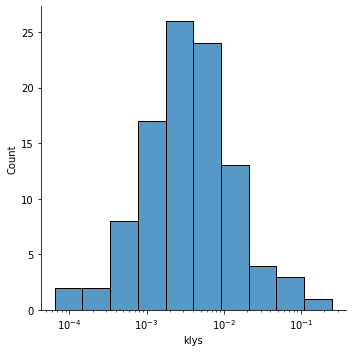

In [61]:
sns.displot(data=df_klys, kind='hist', x=str_klys, log_scale=True, bins=10)

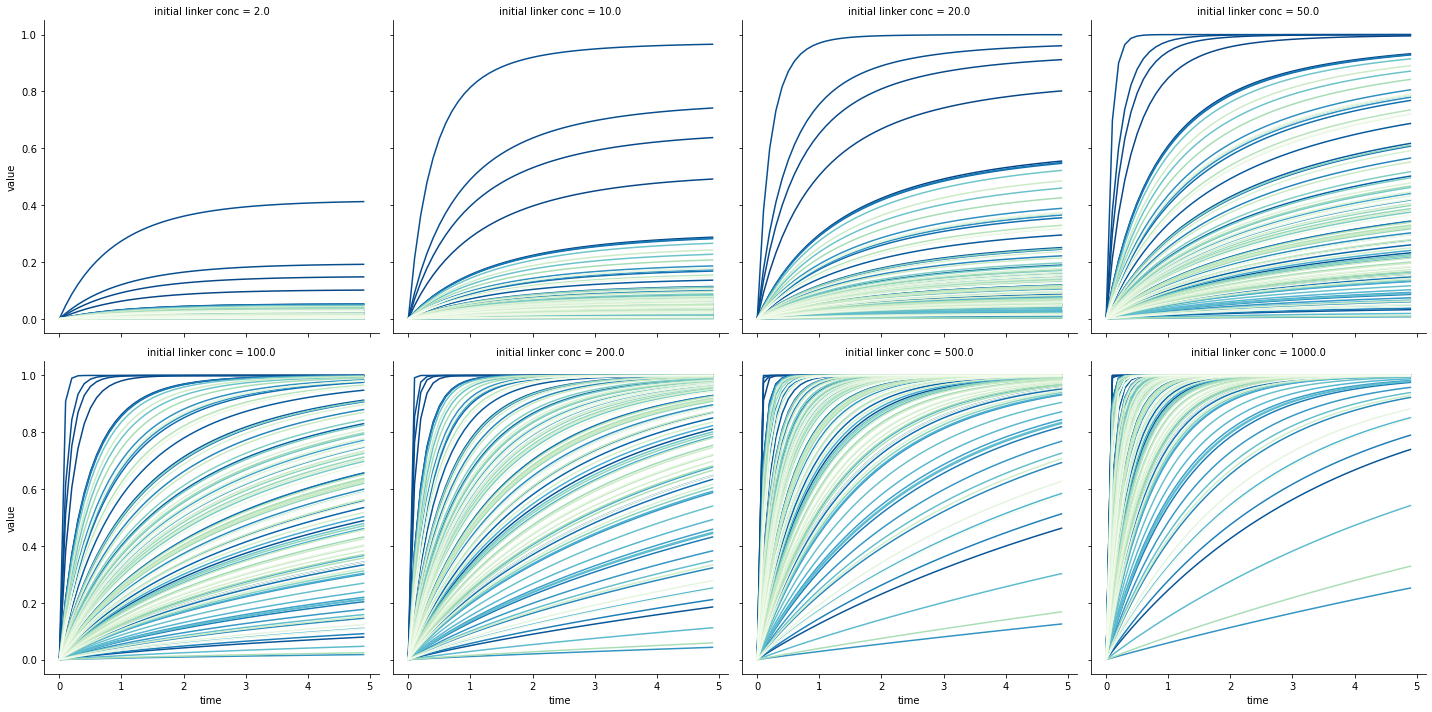

In [46]:
fg = sns.relplot(data=df_concat_mono_only[df_concat_mono_only[str_time] < 5],
                 kind='line' ,x=str_time, y=str_value,hue=str_pos, col=str_conc_linker_initical, facet_kws={'sharey': True}, legend=False, palette='GnBu_r', col_wrap=4)

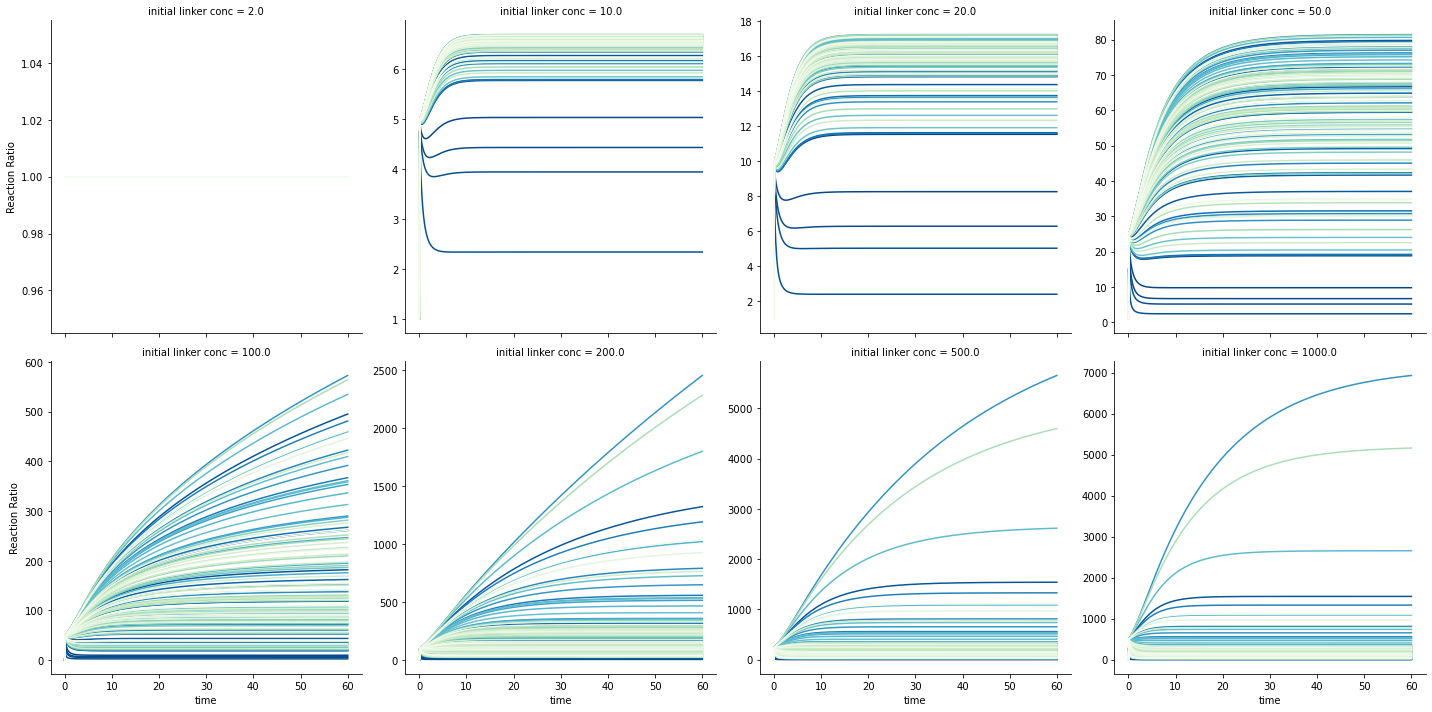

In [47]:
fg = sns.relplot(data=df_concat_mono_only,
                 kind='line' ,x=str_time, y=str_reaction_ratio,hue=str_pos, col=str_conc_linker_initical, facet_kws={'sharey': False}, legend=False, palette='GnBu_r', col_wrap=4)

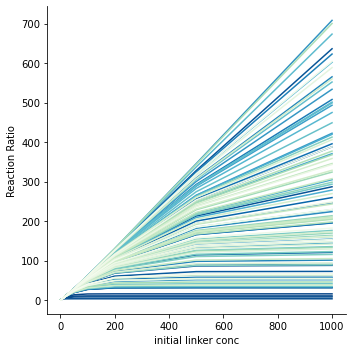

In [49]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint,
                 kind='line' ,x=str_conc_linker_initical, y=str_reaction_ratio,hue=str_pos, legend=False, palette='GnBu_r')

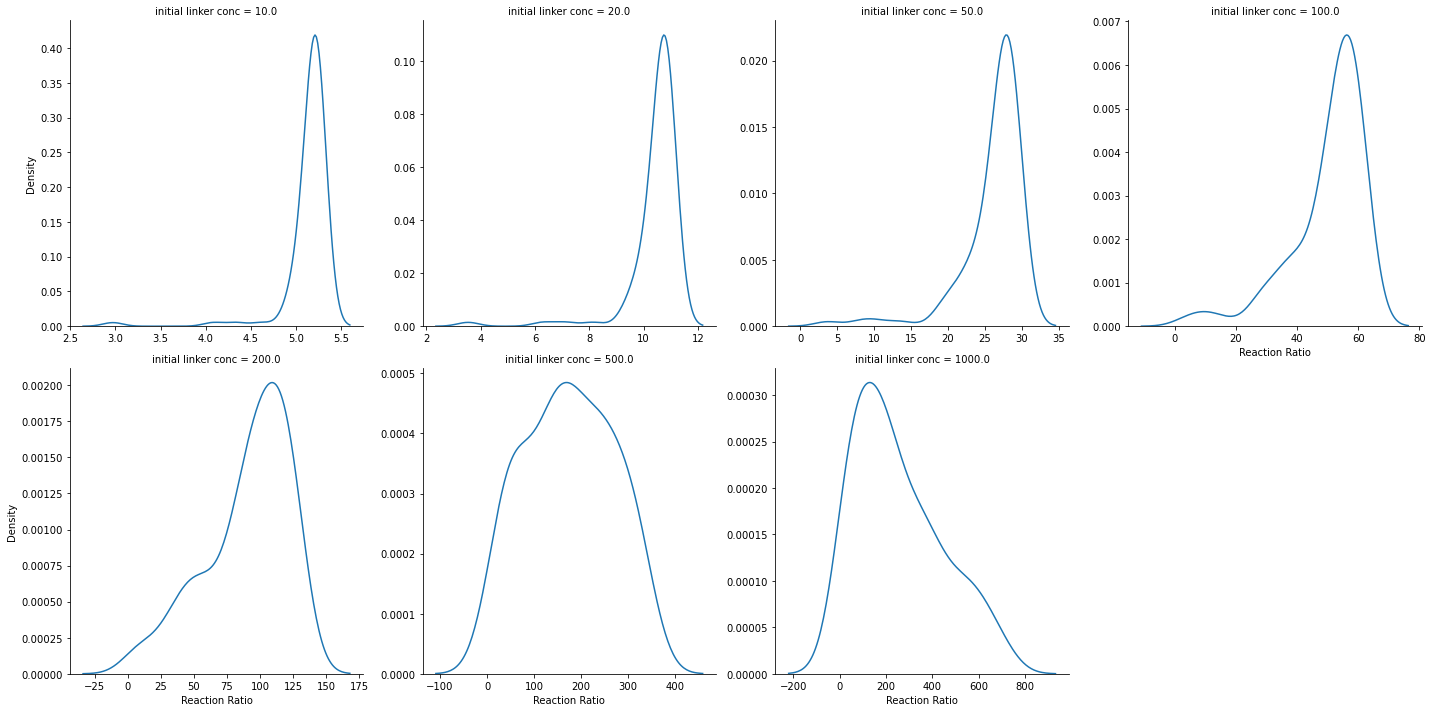

In [52]:
fg = sns.displot(data=df_concat_mono_only_last_timepoint[filter_ref], kind='kde', x=str_reaction_ratio, col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)

In [62]:
df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].median()

initial linker conc
2.0         1.000000
10.0        5.213003
20.0       10.730701
50.0       27.504098
100.0      53.962542
200.0      98.220524
500.0     172.680493
1000.0    207.184904
Name: Reaction Ratio, dtype: float64

In [63]:
df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].mean()

initial linker conc
2.0         1.000000
10.0        5.139554
20.0       10.438418
50.0       26.063213
100.0      50.021734
200.0      90.486904
500.0     174.059534
1000.0    254.338396
Name: Reaction Ratio, dtype: float64

In [64]:
df_klys.sort_values(str_klys)

,variable,klys,pos
21,klys_28,0.000065,28
61,klys_64,0.000089,64
37,klys_42,0.000175,42
67,klys_7,0.000301,7
14,klys_21,0.000349,21
...,...,...,...
0,klys_1,0.025000,1
12,klys_2,0.050000,2
23,klys_3,0.075000,3
34,klys_4,0.100000,4


In [65]:
df_klys.sort_values(str_klys).iloc[49]

variable     klys_77
klys        0.003633
pos               77
Name: 75, dtype: object

In [66]:
df_concat_mono_only_last_timepoint[df_concat_mono_only_last_timepoint[str_reaction_ratio] > 30]

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio,sorted,klys
5,1.0,MonoHydro_1,0.984957,MonoHydro,1,False,200.0,100.0,31.262406,4,0.025000
6,1.0,MonoHydro_1,0.999987,MonoHydro,1,False,500.0,250.0,31.739455,4,0.025000
7,1.0,MonoHydro_1,1.000000,MonoHydro,1,False,1000.0,500.0,31.739880,4,0.025000
44,1.0,MonoHydro_6,0.176680,MonoHydro,6,False,100.0,50.0,56.457290,62,0.002448
45,1.0,MonoHydro_6,0.336949,MonoHydro,6,False,200.0,100.0,107.670756,62,0.002448
...,...,...,...,...,...,...,...,...,...,...,...
791,1.0,MonoHydro_99,0.951608,MonoHydro,99,False,1000.0,500.0,229.771605,55,0.003241
796,1.0,MonoHydro_100,0.612277,MonoHydro,100,False,100.0,50.0,40.389560,18,0.011929
797,1.0,MonoHydro_100,0.865010,MonoHydro,100,False,200.0,100.0,57.061358,18,0.011929
798,1.0,MonoHydro_100,0.995274,MonoHydro,100,False,500.0,250.0,65.654367,18,0.011929


In [67]:
df_concat_mono_only_last_timepoint[df_concat_mono_only_last_timepoint[str_var] == "MonoHydro_28"]

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio,sorted,klys
216,1.0,MonoHydro_28,0.000083,MonoHydro,28,False,2.0,1.0,1.000000,27,0.000065
217,1.0,MonoHydro_28,0.000438,MonoHydro,28,False,10.0,5.0,5.264218,99,0.000065
218,1.0,MonoHydro_28,0.000913,MonoHydro,28,False,20.0,10.0,10.978506,99,0.000065
219,1.0,MonoHydro_28,0.002439,MonoHydro,28,False,50.0,25.0,29.333651,99,0.000065
220,1.0,MonoHydro_28,0.005144,MonoHydro,28,False,100.0,50.0,61.868580,99,0.000065
221,1.0,MonoHydro_28,0.010841,MonoHydro,28,False,200.0,100.0,130.390570,99,0.000065
222,1.0,MonoHydro_28,0.028726,MonoHydro,28,False,500.0,250.0,345.501443,99,0.000065
223,1.0,MonoHydro_28,0.058869,MonoHydro,28,False,1000.0,500.0,708.050202,99,0.000065


In [68]:
df_concat_mono_only_last_timepoint[df_concat_mono_only_last_timepoint[str_var] == "MonoHydro_77"]

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio,sorted,klys
608,1.0,MonoHydro_77,0.004642,MonoHydro,77,False,2.0,1.0,1.000000,76,0.003633
609,1.0,MonoHydro_77,0.024199,MonoHydro,77,False,10.0,5.0,5.213294,50,0.003633
610,1.0,MonoHydro_77,0.049816,MonoHydro,77,False,20.0,10.0,10.732095,50,0.003633
611,1.0,MonoHydro_77,0.127714,MonoHydro,77,False,50.0,25.0,27.514105,50,0.003633
612,1.0,MonoHydro_77,0.250672,MonoHydro,77,False,100.0,50.0,54.003677,50,0.003633
613,1.0,MonoHydro_77,0.456615,MonoHydro,77,False,200.0,100.0,98.371198,50,0.003633
614,1.0,MonoHydro_77,0.804254,MonoHydro,77,False,500.0,250.0,173.265190,50,0.003633
615,1.0,MonoHydro_77,0.966461,MonoHydro,77,False,1000.0,500.0,208.210427,50,0.003633


In [69]:
df_concat_mono_only_last_timepoint[df_concat_mono_only_last_timepoint[str_var] == "MonoHydro_4"]

,time,variable,value,species,pos,is_linker,initial linker conc,Linker Ratio,Reaction Ratio,sorted,klys
24,1.0,MonoHydro_4,0.120193,MonoHydro,4,False,2.0,1.0,1.000000,3,0.1
25,1.0,MonoHydro_4,0.490443,MonoHydro,4,False,10.0,5.0,4.080462,1,0.1
26,1.0,MonoHydro_4,0.754978,MonoHydro,4,False,20.0,10.0,6.281383,1,0.1
27,1.0,MonoHydro_4,0.976732,MonoHydro,4,False,50.0,25.0,8.126369,1,0.1
28,1.0,MonoHydro_4,0.999645,MonoHydro,4,False,100.0,50.0,8.317002,1,0.1
29,1.0,MonoHydro_4,1.000000,MonoHydro,4,False,200.0,100.0,8.319958,1,0.1
30,1.0,MonoHydro_4,1.000000,MonoHydro,4,False,500.0,250.0,8.319958,1,0.1
31,1.0,MonoHydro_4,1.000000,MonoHydro,4,False,1000.0,500.0,8.319958,1,0.1


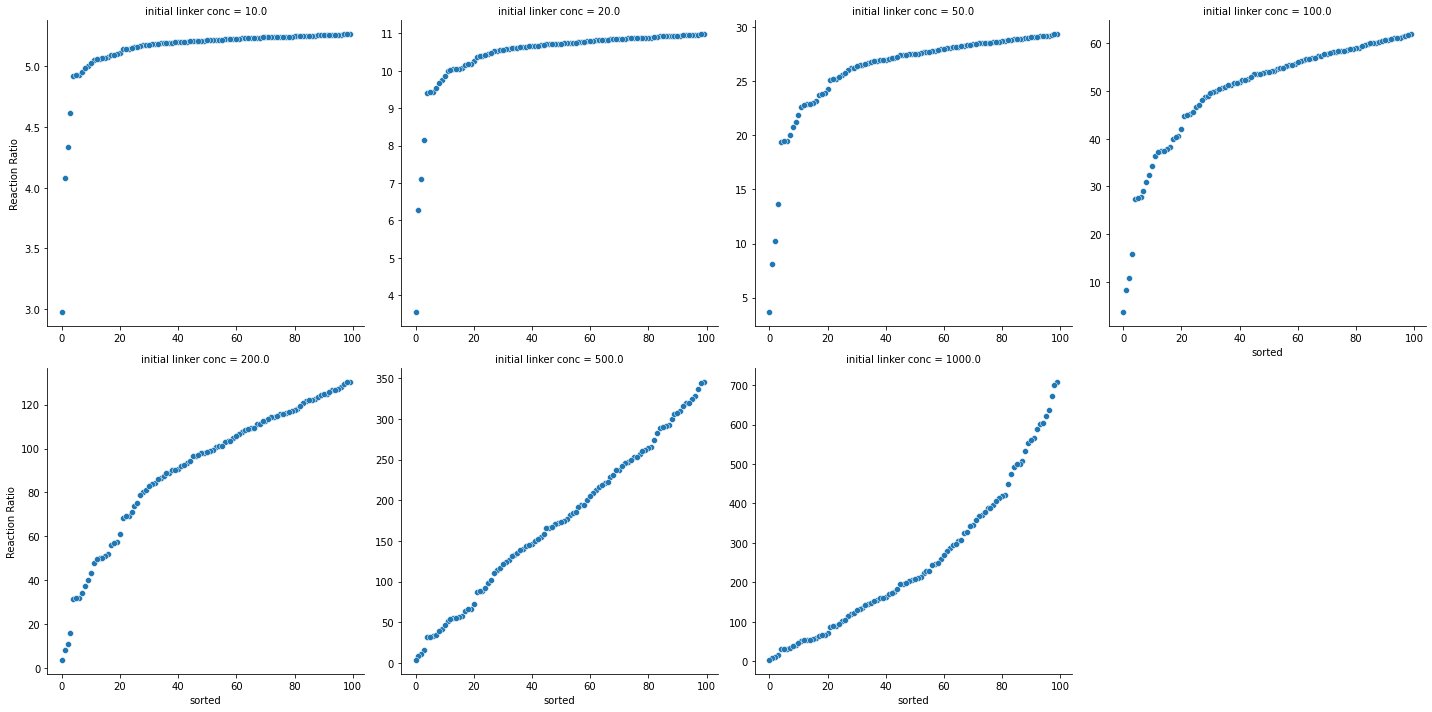

In [70]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint[filter_ref], y=str_reaction_ratio, x='sorted', col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)

In [71]:
df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].min()

initial linker conc
2.0       1.000000
10.0      2.973738
20.0      3.541852
50.0      3.650033
100.0     3.650335
200.0     3.650335
500.0     3.650335
1000.0    3.650335
Name: Reaction Ratio, dtype: float64

In [72]:
df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].max()

initial linker conc
2.0         1.000000
10.0        5.264218
20.0       10.978506
50.0       29.333651
100.0      61.868580
200.0     130.390570
500.0     345.501443
1000.0    708.050202
Name: Reaction Ratio, dtype: float64

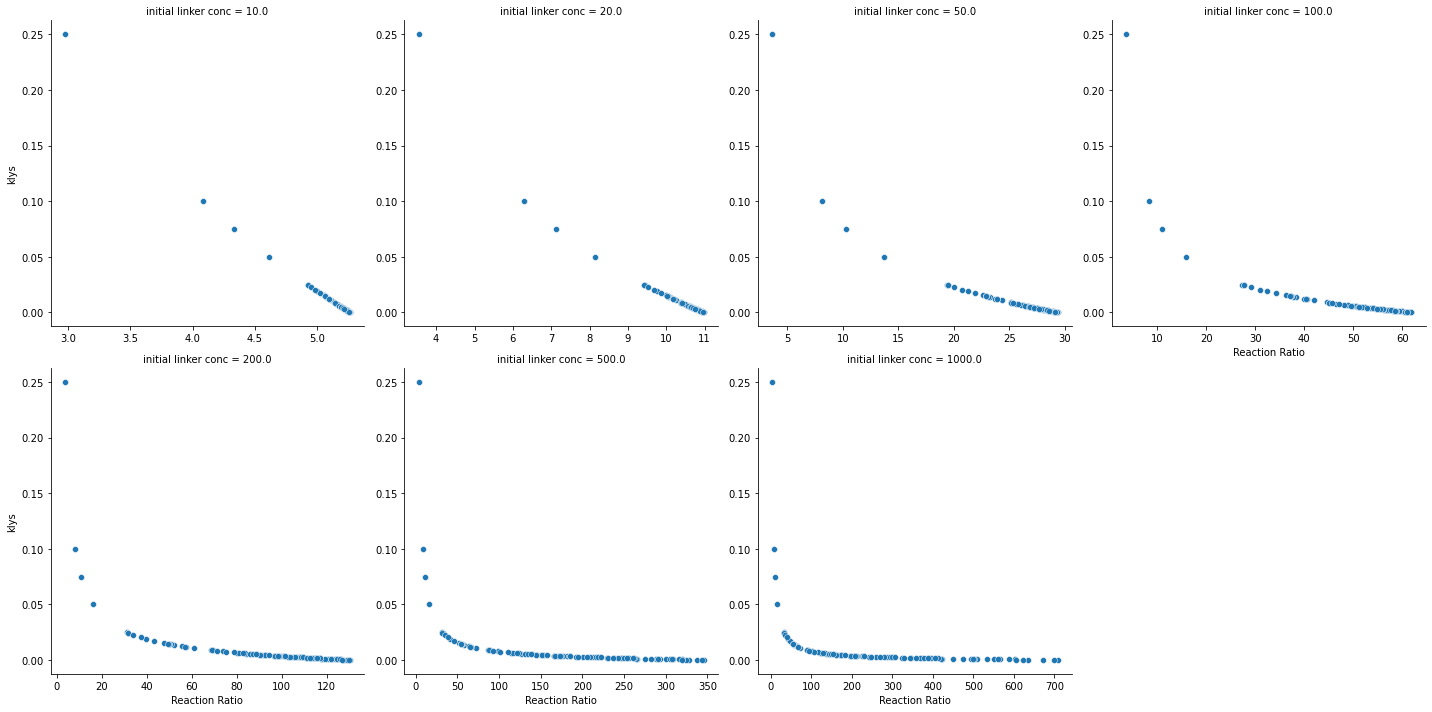

In [73]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint[filter_ref],
                 kind='scatter', x=str_reaction_ratio, y=str_klys, col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)

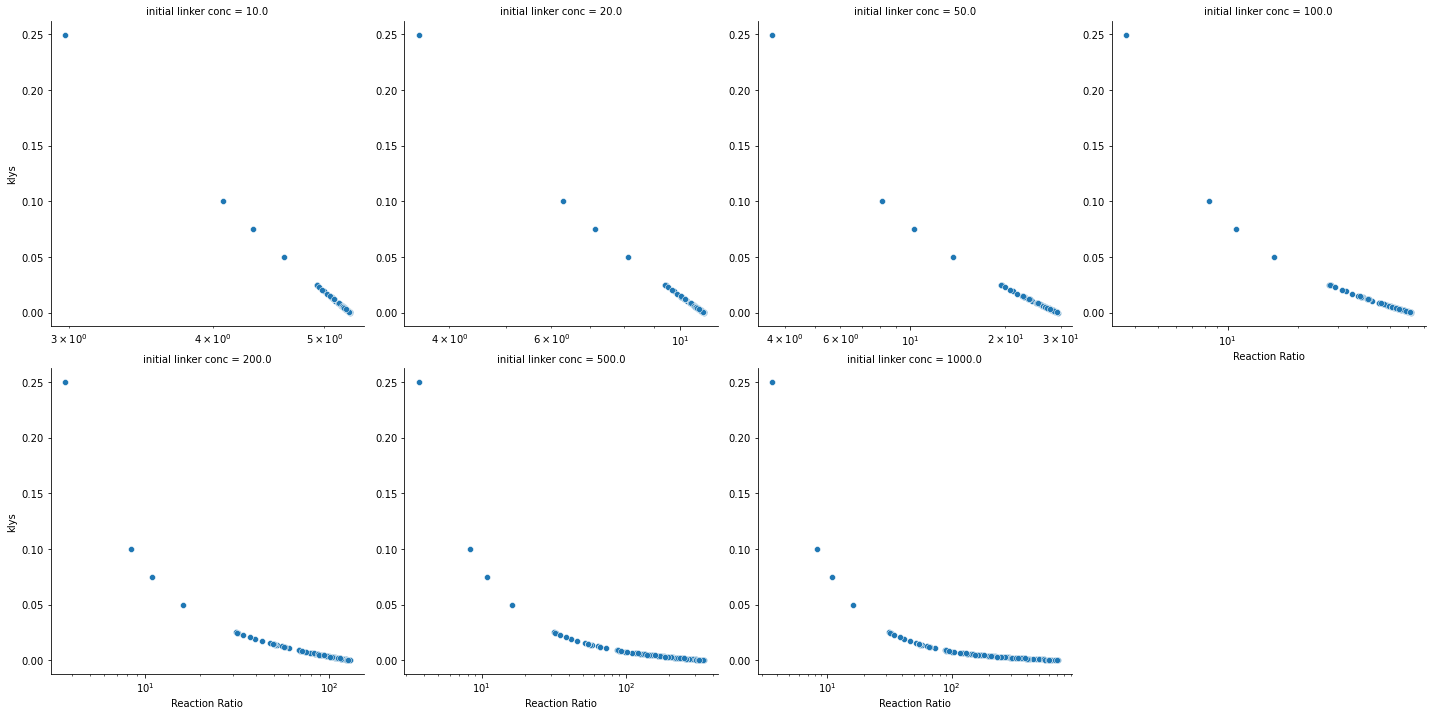

In [74]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint[filter_ref],
                 kind='scatter', x=str_reaction_ratio, y=str_klys, col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)
for ax in fg.axes:
    ax.set_xscale('log')

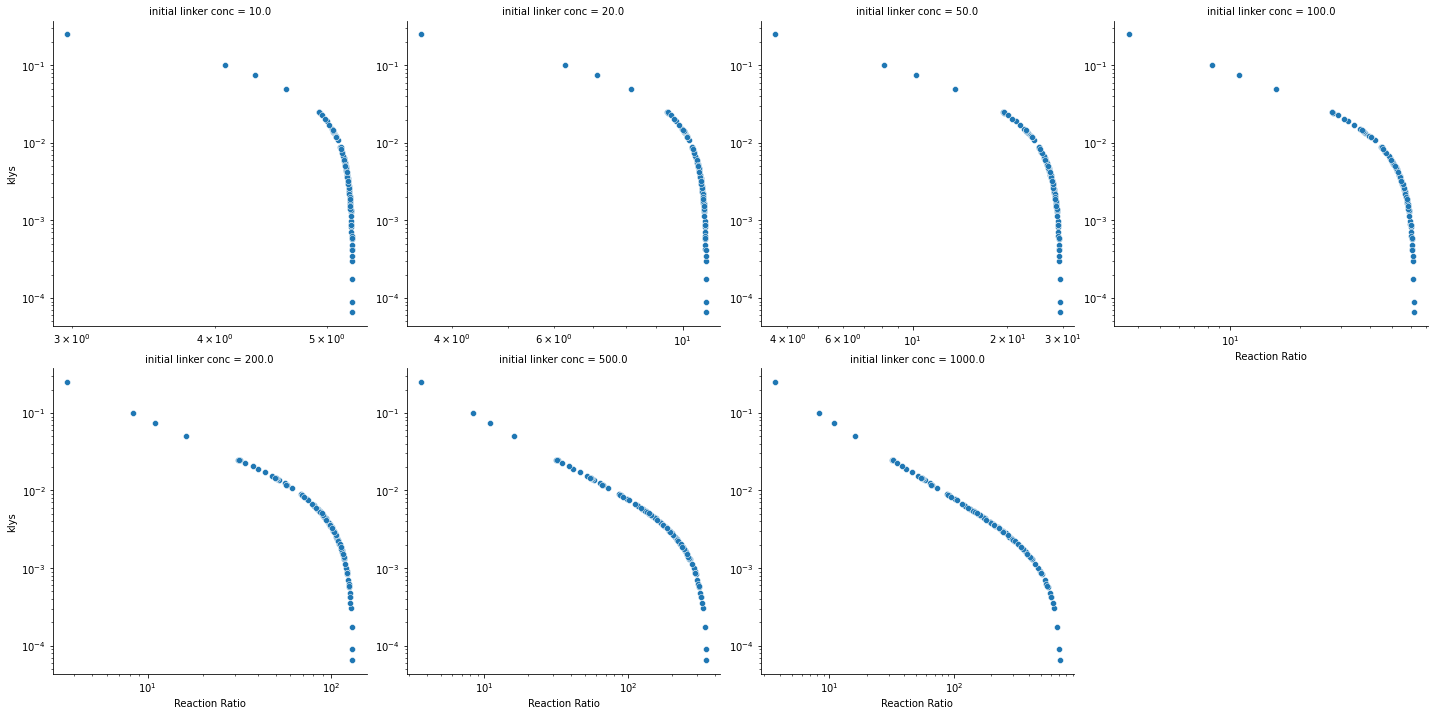

In [75]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint[filter_ref],
                 kind='scatter', x=str_reaction_ratio, y=str_klys, col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)
for ax in fg.axes:
    ax.set_yscale('log')
    ax.set_xscale('log')

In [76]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)


np.random.seed(0)

x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

print(params)

[3.05931973 1.45754553]


In [77]:
def func_reci(x, a, n):
    return 1/(a*x**(n))

In [78]:
def func_reci_simple(x, a):
    return 1/(a*x)

In [79]:
def func_exp(x, a, n):
    return a*np.exp(-x**n)

In [80]:
func_reci(5,1,1)

0.2

<AxesSubplot:>

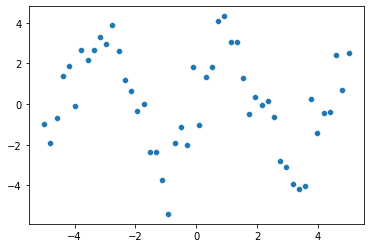

In [81]:
sns.scatterplot(x=x_data, y=y_data)

<AxesSubplot:>

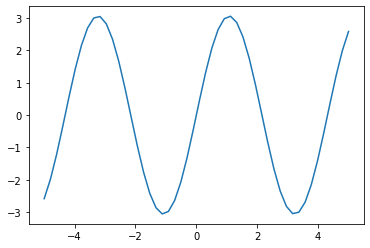

In [82]:
sns.lineplot(x=x_data, y=test_func(x_data, params[0], params[1]))

In [83]:
x_data = np.geomspace(0.01, 5, num=50)

<AxesSubplot:>

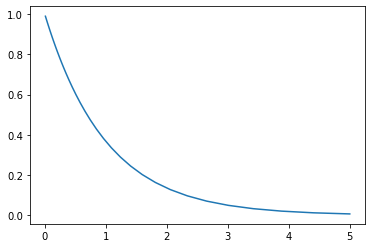

In [84]:
sns.lineplot(x=x_data, y=func_exp(x_data, a=1, n=1))

In [85]:
def fit_wrapper(func, xdata, ydata, p0):
    params, params_covariance = optimize.curve_fit(func, xdata, ydata, p0=p0)
    perr = np.sqrt(np.diag(params_covariance))
    res_dict = {}
    for n, p in enumerate(params):
        res_dict[f"p_{n}"] = [p]
    for n, p in enumerate(perr):
        res_dict[f"p_err_{n}"] = [p]
    return pd.DataFrame(res_dict)

In [86]:
np.polynomial.polynomial.Polynomial.fit(x=x_data, y=y_data, deg=2)

Polynomial([-1.52049984,  1.12710788,  3.48823948], domain=[0.01, 5.  ], window=[-1.,  1.])

In [87]:
df_fit_exp = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical).apply(lambda x: fit_wrapper(func_exp, x[str_klys],x[str_reaction_ratio], p0=[1, 1])).reset_index()
df_fit_exp

/opt/miniconda3/envs/te/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



,initial linker conc,level_1,p_0,p_1,p_err_0,p_err_1
0,2.0,0,1.000000,15.921579,inf,inf
1,10.0,0,5.342680,0.645306,0.014645,0.014597
2,20.0,0,10.438418,24.600691,inf,inf
3,50.0,0,26.063213,44.743196,inf,inf
4,100.0,0,50.021734,47.872103,inf,inf
5,200.0,0,90.486904,48.091833,inf,inf
6,500.0,0,174.059534,129.221532,inf,inf
7,1000.0,0,254.338397,39.447705,inf,inf


In [88]:
df_fit = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical).apply(lambda x: fit_wrapper(func_reci, x[str_reaction_ratio], x[str_klys], p0=[1, 1])).reset_index()
df_fit

/opt/miniconda3/envs/te/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



,initial linker conc,level_1,p_0,p_1,p_err_0,p_err_1
0,2.0,0,99.065039,1.000000,inf,inf
1,10.0,0,-5.648856,18.995199,2.515602e+10,2.261228e+10
2,20.0,0,0.080505,3.064480,1.184961e-02,1.018950e-01
3,50.0,0,0.415344,1.720917,3.019840e-02,4.381848e-02
4,100.0,0,0.680440,1.345428,2.825168e-02,2.345834e-02
5,200.0,0,0.872512,1.166259,1.896860e-02,1.185873e-02
6,500.0,0,0.989502,1.080706,7.685628e-03,4.178111e-03
7,1000.0,0,1.011261,1.066551,5.127728e-03,2.726011e-03


In [89]:
df_fit_simple = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical).apply(lambda x: fit_wrapper(func_reci_simple, x[str_reaction_ratio], x[str_klys], p0=[1])).reset_index()
df_fit_simple

,initial linker conc,level_1,p_0,p_err_0
0,2.0,0,99.065039,27.339386
1,10.0,0,15.912809,3.477463
2,20.0,0,6.397038,1.031831
3,50.0,0,2.128992,0.168604
4,100.0,0,1.374884,0.053535
5,200.0,0,1.187756,0.021179
6,500.0,0,1.141794,0.008462
7,1000.0,0,1.136982,0.006494


In [90]:
def get_matching_params(x, df_fit, func, param_names):
    params_list = []
    params_series = df_fit[df_fit[str_conc_linker_initical] == x.name]
    for p_name in param_names:
        params_list.append(params_series[p_name].iloc[0])
    return func(x, *params_list)

In [91]:
df_concat_mono_only_last_timepoint[str_klys + "_fit"] = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].transform(get_matching_params, df_fit, func_reci, param_names=["p_0", "p_1"])

In [92]:
df_concat_mono_only_last_timepoint[str_klys + "_fit_simple"] = df_concat_mono_only_last_timepoint.groupby(str_conc_linker_initical)[str_reaction_ratio].transform(get_matching_params, df_fit, func_reci_simple, param_names=["p_0"])

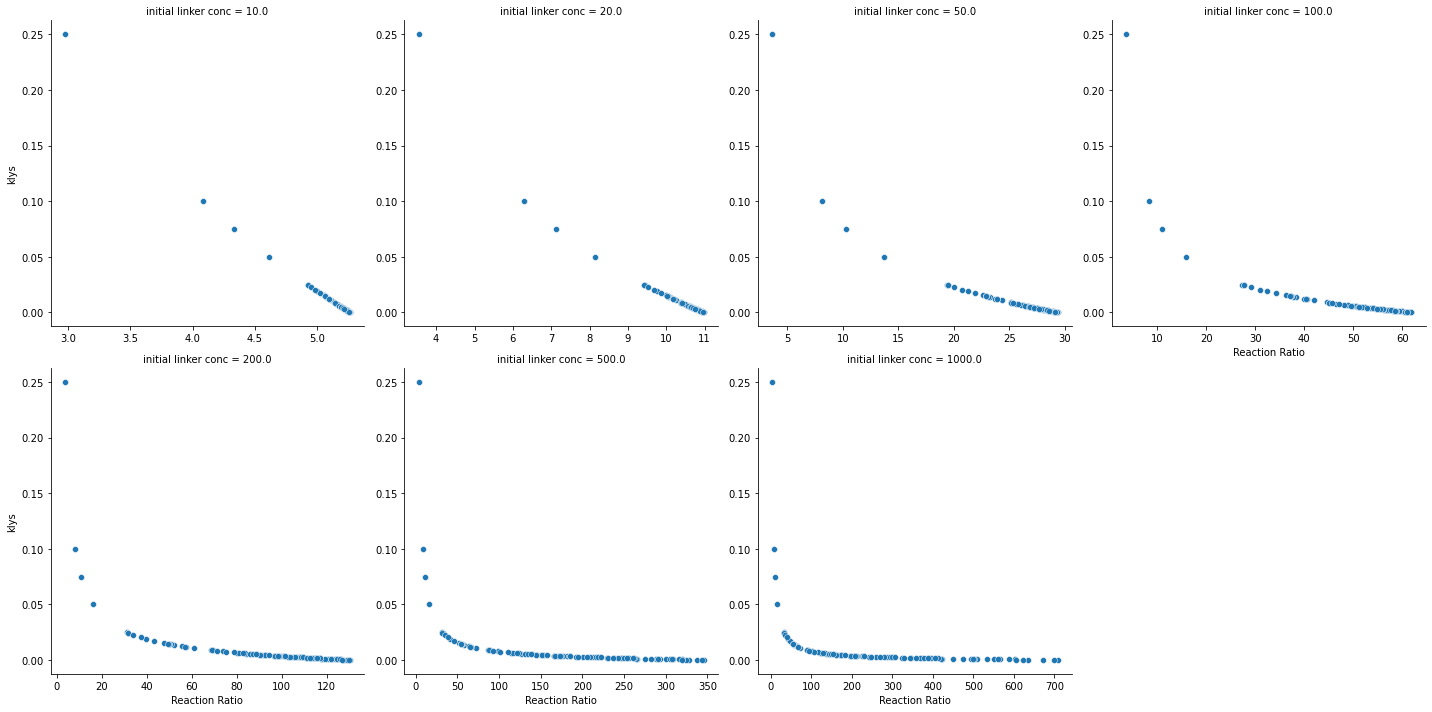

In [93]:
fg = sns.relplot(data=df_concat_mono_only_last_timepoint[filter_ref],
                 kind='scatter', x=str_reaction_ratio, y=str_klys, col=str_conc_linker_initical, facet_kws={'sharey': False, 'sharex': False}, col_wrap=4)

In [94]:
fg = fg.map(sns.lineplot, str_reaction_ratio, str_klys + "_fit", color='red')
fg = fg.map(sns.lineplot, str_reaction_ratio, str_klys + "_fit_simple", color='orange')

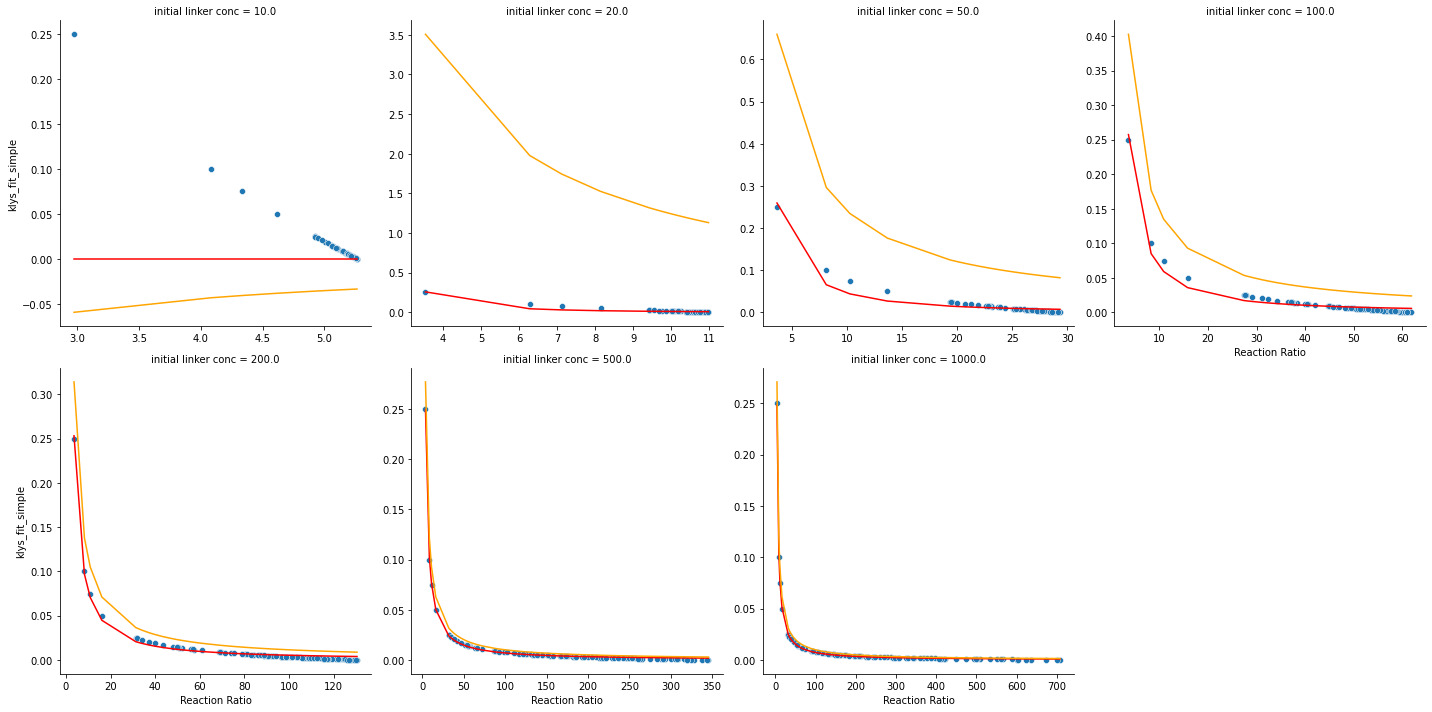

In [95]:
fg.fig

In [96]:
for ax in fg.axes:
    ax.set_yscale('log')
    ax.set_xscale('log')

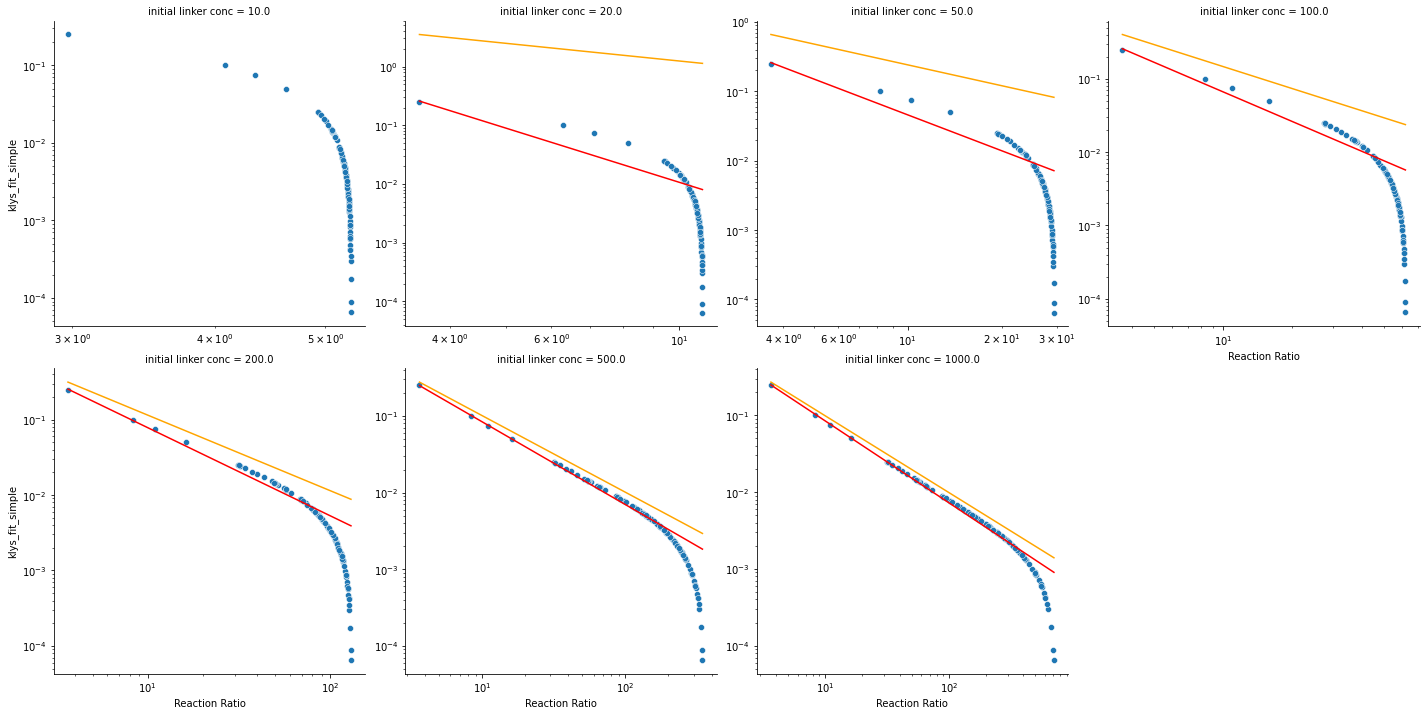

In [97]:
fg.fig

In [276]:
df_concat_mono_only_last_timepoint[[str_klys, str_reaction_ratio]]

,klys,Reaction Ratio
0,0.025000,1.000000
1,0.025000,4.923302
2,0.025000,9.408961
3,0.025000,19.343489
4,0.025000,27.382195
...,...,...
795,0.011929,23.845800
796,0.011929,40.389560
797,0.011929,57.061358
798,0.011929,65.654367


In [277]:
#pd.pivot(df_concat_mono_only_last_timepoint, values=[str_reaction_ratio, str_klys], columns=str_conc_linker_initical, index=str_pos).to_csv("sim_data.csv")
#df_concat_mono_only.to_csv("sim_data_long.csv", index=False)